# Test for PSO + FCM

In [0]:
!pip install deap

In [0]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter,MultipleLocator

import numpy as np
import pandas as pd
import scipy as sp
import seaborn as sns
from scipy.spatial import distance
from  sklearn.preprocessing  import MinMaxScaler,StandardScaler

import math
import operator
import random
import math
import os
import sys

from deap import base
from deap import benchmarks
from deap import creator
from deap import tools

np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
sys.path.append('drive//My Drive//Colab Notebooks//PUC//Fuzzy')

In [0]:
# from fuzzy_c_means import FuzzyCMeans
# from fuzzy_validity_metrics import FuzzyClusteringValidatityMetrics

## Simple dataset Testing FPSO and FCM

In [0]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
from seaborn import scatterplot as scatter
import time

# create artifitial dataset
n_samples = 3000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here
centers = [(-5, 0), (0, 0), (10, 2)]

X,_ = make_blobs(n_samples=n_samples, n_features=2, cluster_std=2,
                  centers=centers, shuffle=False, random_state=42)



In [0]:
def plot_data_with_centroids(X,fcm_centers,fcm_labels):
  plt.style.use('seaborn-whitegrid')
  f, axes = plt.subplots(1, 1, figsize=(10,10))
  scatter(X[:,0], X[:,1], ax=axes, hue=fcm_labels)
  scatter(fcm_centers[:,0], fcm_centers[:,1], ax=axes,marker="s",s=200)
  plt.grid(True)
  plt.title('FCM clustering result')
  plt.axis('equal')
  plt.show()

In [0]:
fcm_vanilla_labels

array([1, 1, 1, ..., 0, 0, 0])

u_initial: 
[[0.57 0.23 0.19]
 [0.31 0.51 0.18]
 [0.43 0.17 0.4 ]
 ...
 [0.44 0.12 0.43]
 [0.38 0.24 0.37]
 [0.06 0.45 0.49]]

Centroids : 
[[ 9.96  1.91]
 [-5.13  0.1 ]
 [ 0.22 -0.01]]

Validity Measures : 
Fuzzy Partition Coefficient: 0.9028
Fuzzy Partition Entropy: 0.1759
Generalized Silhouette: 0.4758



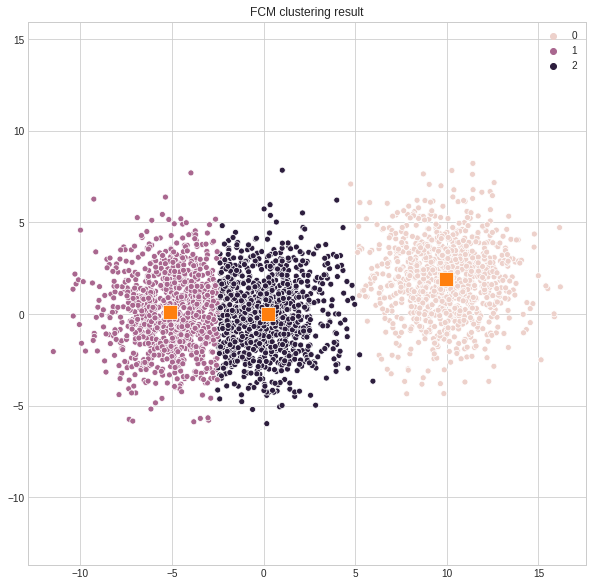


--- Total run time: 2.700 seconds ---

Final centroids: 
[[ 9.96  1.91]
 [-5.13  0.1 ]
 [ 0.22 -0.01]]


In [0]:
start_time = time.time()

fcm = FuzzyCMeans(m=1.5)
fcm.fit(dataset=X,n_clusters=3,tolerance=0.001,verbose=1,max_iterations=100)
fcm_centers = fcm.centroids
fcm_labels  = fcm.u_membership.argmax(axis=1)

print('')
plot_data_with_centroids(X,fcm_centers,fcm_labels)
d_time = (time.time() - start_time)
print('')
print("--- Total run time: %.3f seconds ---" % d_time)
print('')
print('Final centroids: ')
print(fcm_centers)

In [0]:
def fcm_clustering():
    fcm = FuzzyCMeans(m=m)
    fcm.fit(dataset=X,n_clusters=n_clusters,tolerance=0.0001,verbose=0,max_iterations=500)
    return fcm

def calculate_fitness_by_centroids(centroids):
    u_membership = calculate_membership_matrix(X,centroids)
    dist_matrix = distance.cdist(X,centroids)
    J = (u_membership**m * dist_matrix).sum()
    return (1/J,)

def calculate_membership_matrix(data_points: np.array, centroids:np.array):

    distance_to_centroids_matrix = distance.cdist(data_points,centroids)

    inv_dist = distance_to_centroids_matrix**(-1)
    numerator = inv_dist ** (2/(m - 1))

    denominator = (inv_dist ** (2/(m - 1))).sum(axis=1) 
    denominator = np.tile(np.reshape(denominator,(data_points.shape[0],1)),centroids.shape[0])
    u_membership = numerator / denominator
    return u_membership

def generate( size,pmin, pmax, smin, smax):
    # fcm = fcm_clustering()
    random = np.random.RandomState()
    initial_centroids = random.rand(size[0],size[1])
    print('Initial particle position: ')
    print(initial_centroids)
    print('')
    print('Initial Fitness: ')
    print(calculate_fitness_by_centroids(initial_centroids))
    print('')
    print('')

    part = creator.Particle(initial_centroids) 
    speed = np.random.uniform(smin,smax,np.shape(part))
    part.speed = speed
    part.smin = smin
    part.smax = smax
    return part

def updateParticle(part, best, phi1, phi2):
    u1 = np.random.uniform(0, phi1, np.shape(part))
    u2 = np.random.uniform(0, phi2, np.shape(part))
    v_u1 = u1 * (part.best - part)
    v_u2 = u2 * (best - part)
    part.speed += v_u1 + v_u2
    part += part.speed
    # print('Current particle position: ')
    # print(part)
    # print('')
    # print('Current Fitness: ')
    # print(calculate_fitness_by_centroids(part))
def pso_optimization(size): 
    toolbox = base.Toolbox()
    toolbox.register("particle", generate,size=size,pmin=0,pmax=1, smin=-1, smax=1)
    toolbox.register("population", tools.initRepeat, list, toolbox.particle)
    toolbox.register("update", updateParticle, phi1=1, phi2=1)
    toolbox.register("evaluate",calculate_fitness_by_centroids)

    pop = toolbox.population(n=population)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "evals"] + stats.fields
    best = None
    iter_no_change = 0
    
    for g in range(GEN):
        iter_no_change += 1
        for part in pop:
            part.fitness.values = toolbox.evaluate(part)
            if part.best is None or part.best.fitness < part.fitness:
                part.best = creator.Particle(part)
                part.best.fitness.values = part.fitness.values
            if best is None or best.fitness < part.fitness:
                best = creator.Particle(part)
                best.fitness.values = part.fitness.values
                iter_no_change = 0
        for part in pop:
            toolbox.update(part, best)
        if iter_no_change >= 50:
          print('converged at generation ',g)
          break
        logbook.record(gen=g, evals=len(pop), **stats.compile(pop))
    print('')
    print('Best particle: ')
    print(best)
    print('')
    print('Final fitness: ')
    print(calculate_fitness_by_centroids(best))
    return pop, logbook, best

In [0]:
w = 0.9
GEN = 100
population = 20
n_clusters = 3
n_dim = 2
m = 1.5
size = (n_clusters,n_dim)
size

(3, 2)

In [0]:
creator.create("FitnessMax", base.Fitness, weights=(w,))
creator.create("Particle", np.ndarray, fitness=creator.FitnessMax, speed=list, 
    smin=None, smax=None, best=None)
_,_,best =  pso_optimization(size)

/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/usr/local/lib/python3.6/dist-packages/deap/creator.py:141: RuntimeWarning: A class named 'Particle' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


Initial particle position: 
[[0.74 0.5 ]
 [0.42 0.47]
 [0.43 0.22]]

Initial Fitness: 
(9.529620390037201e-05,)


Initial particle position: 
[[0.73 0.22]
 [0.69 0.83]
 [0.21 0.07]]

Initial Fitness: 
(9.523003110573659e-05,)


Initial particle position: 
[[0.39 0.47]
 [0.78 0.1 ]
 [0.93 0.19]]

Initial Fitness: 
(9.509848481790673e-05,)


Initial particle position: 
[[0.01 0.69]
 [1.   0.72]
 [0.12 0.19]]

Initial Fitness: 
(9.53760702040995e-05,)


Initial particle position: 
[[0.74 0.15]
 [0.54 0.5 ]
 [0.2  0.29]]

Initial Fitness: 
(9.529870189850135e-05,)


Initial particle position: 
[[0.55 0.05]
 [0.67 0.08]
 [0.26 0.48]]

Initial Fitness: 
(9.525026740078933e-05,)


Initial particle position: 
[[0.   0.37]
 [0.67 0.93]
 [0.35 0.34]]

Initial Fitness: 
(9.53244834421735e-05,)


Initial particle position: 
[[0.08 0.75]
 [0.89 0.09]
 [0.06 0.58]]

Initial Fitness: 
(9.535106389643123e-05,)


Initial particle position: 
[[0.85 0.71]
 [0.73 0.69]
 [0.23 0.56]]

Initial Fitness: 
(9.

Result for best result of PSO: 
Centroids: 
[[-4.27  0.17]
 [ 9.97  1.84]
 [-0.46 -0.97]]


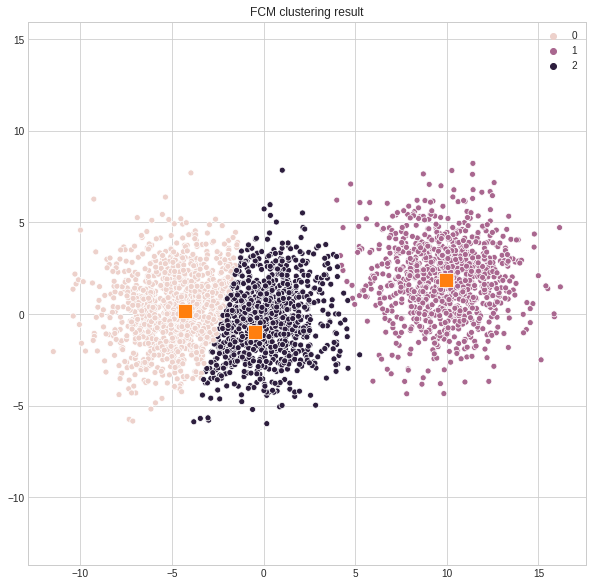

Fuzzy Partition Coefficient:  0.8843983123230643
Fuzzy Partition Entropy:  0.20809366615469652
Generalized Silhouette:  0.45969824500620415



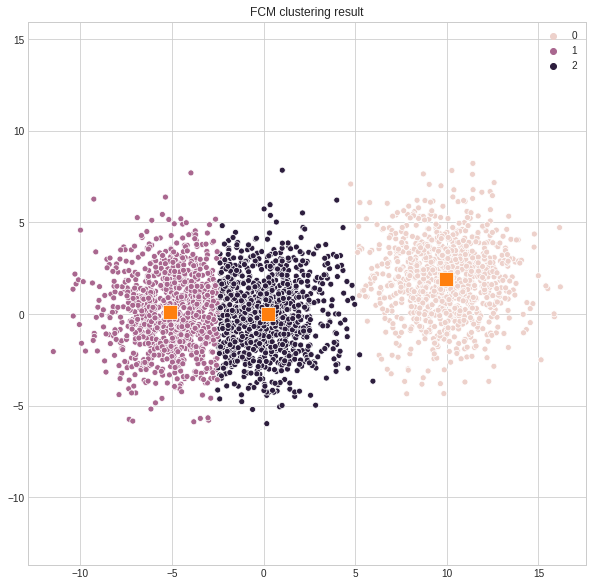

Metrics for best result of FCM: 
Centroids: 
[[ 9.96  1.91]
 [-5.13  0.1 ]
 [ 0.22 -0.01]]
Fuzzy Partition Coefficient:  0.9027605684712301
Fuzzy Partition Entropy:  0.17585124593595147
Generalized Silhouette:  0.4758057941848172



In [0]:
u_membership_pso_fcm = calculate_membership_matrix(centroids=best,data_points=X)

fcm_metrics = FuzzyClusteringValidatityMetrics()
print('Result for best result of PSO: ')
print('Centroids: ')
print(best)
fcm_metrics.all(u_membership = u_membership_pso_fcm,X = X)
plot_data_with_centroids(X,best,u_membership_pso_fcm.argmax(axis=1))
print('Fuzzy Partition Coefficient: ', fcm_metrics.fpc())
print('Fuzzy Partition Entropy: ', fcm_metrics.fpe())
print('Generalized Silhouette: ', fcm_metrics.generalized_silhouette())
print('')

u_membership_fcm_vanilla = fcm_vanilla.u_membership
fcm_metrics = FuzzyClusteringValidatityMetrics()
fcm_metrics.all(u_membership = u_membership_fcm_vanilla,X = X)
plot_data_with_centroids(X,fcm_vanilla.centroids,fcm_vanilla.u_membership.argmax(axis=1))
print('Metrics for best result of FCM: ')
print('Centroids: ')
print(fcm_vanilla.centroids)
print('Fuzzy Partition Coefficient: ', fcm_metrics.fpc())
print('Fuzzy Partition Entropy: ', fcm_metrics.fpe())
print('Generalized Silhouette: ', fcm_metrics.generalized_silhouette())
print('')


In [0]:
fcm_vanilla.u_membership

array([[0.  , 0.99, 0.01],
       [0.  , 0.81, 0.19],
       [0.  , 1.  , 0.  ],
       ...,
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ],
       [1.  , 0.  , 0.  ]])

In [0]:
print('Metrics for best result of PSO+FCM: ')
fcm_hybrid = FuzzyCMeans()
fcm_hybrid.fit(dataset=X,n_clusters=3,initial_u_membership = u_membership_pso_fcm,tolerance=0.001,verbose=2,max_iterations=100)

Metrics for best result of PSO+FCM: 
u_initial: 
[[1.   0.   0.  ]
 [0.9  0.   0.09]
 [0.99 0.   0.01]
 ...
 [0.   1.   0.  ]
 [0.   0.99 0.  ]
 [0.   1.   0.  ]]
Iteration: 1 
Iteration: 2 
Iteration: 3 
Iteration: 4 
Iteration: 5 
Iteration: 6 
Iteration: 7 
Iteration: 8 
Iteration: 9 
Iteration: 10 
Iteration: 11 
Iteration: 12 
Iteration: 13 

Centroids : 
[[-5.06  0.08]
 [10.03  1.92]
 [ 0.16 -0.  ]]

Validity Measures : 
Fuzzy Partition Coefficient: 0.7500
Fuzzy Partition Entropy: 0.4533
Generalized Silhouette: 0.4027


In [0]:
import numpy as np
from scipy.spatial import distance
from scipy.linalg import norm
from fuzzy_validity_metrics import FuzzyClusteringValidatityMetrics

class FuzzyCMeans:
    
      """
      Fuzzy C-Means implementation based on  J. C. Bezdek, 
      Pattern Recognition with Fuzzy Objective Function Algorithms (1981).
      <https://doi.org/10.1007/978-1-4757-0450-1>

      """
      def __init__(self,random_state = None,m = 2):

            if(random_state is not None):
              random = np.random.RandomState(random_state)
            else:
              random = np.random.RandomState()
            self.random = random
            self.random_state = random_state
            self.m = m
            self.n_clusters = None
            self.n_dim = None
            self.u_initial, self.centroids_initial = None, None
            self.u_membership, self.centroids = None, None
            self.validity_metrics, self.n_data_points  =None, None

      def initialize_u_membership(self):

            """
            Initialize membership matrix U where the sum of lines is equal to 1.

            Parameters:
             ------x------

            Returns:

            u_membership (np.array): fuzzy membership matrix (n x c) where
            n = number of data points and c = number of clusters.

            """
            random_matrix = self.random.rand(self.n_data_points,self.n_clusters)
            return random_matrix / np.tile(np.reshape(random_matrix.sum(axis=1),(self.n_data_points,1)),self.n_clusters)
            
      def calculate_cluster_centroids(self, u_membership_input: np.array,data_points: np.array):
            """
            Calculate centroids for each cluster based on data points and current 
            membership matrtix.

            Parameters:

            data_points (2D numpy.array): matrix of datapoints (n x k) where
            n = number of data points and k = number of dimensions.

            u_membership_input (2D numpy.array): fuzzy membership matrix (n x c) where
            n = number of data points and c = number of clusters.

            m (float): fuzzy coefficient

            Returns:

            centroids (np.array): calculated centroids for c number of clusters.

            """

            u_membership = u_membership_input**self.m
            numerator = np.dot(u_membership.T,data_points)

            denominator = np.reshape((u_membership).sum(axis=0), (self.n_clusters,1))
            denominator = np.tile(denominator,self.n_dim)

            self.centroids =  numerator / denominator
            return self.centroids

      def calculate_membership_matrix(self, data_points: np.array, centroids:np.array):
            
            """
            Calculate membership matrix based on current centroids, data points 
            and fuzzy coefficient.

            Parameters:

            data_points (2D numpy.array): matrix of datapoints (n x k) where
            n = number of data points and k = number of dimensions.

            centroids (np.array): calculated centroids for c number of clusters.

            """
            if (np.float(self.m) <= 1.02):
              print(self.m)
              self.m = 1.02

            distance_to_centroids_matrix = distance.cdist(data_points,centroids)

            inv_dist = distance_to_centroids_matrix**(-1)
            numerator = inv_dist ** (2/(self.m - 1))

            denominator = (inv_dist ** (2/(self.m - 1))).sum(axis=1) 
            denominator = np.tile(np.reshape(denominator,(self.n_data_points,1)),self.n_clusters)
            u_membership = numerator / denominator
            return u_membership


      def fit(self, dataset: np.array, n_clusters: int, max_iterations = 1000,tolerance = 0.000001,initial_u_membership = None,verbose = 0):
          
            """
            Execute the FCM algorithm.

            Parameters:

            data (2D numpy.array): dataset (n x k) where
            n = number of data points and k = number of dimensions.
            
            n_clusters (int): number of clusters to partition the dataset

            max_iterations (int): maximum number of iterations.

            tolerance (float): minimum tolerance to stop iterations.

            u_membership (2D numpy.array): fuzzy membership matrix (n x c) where
            
            m (float): fuzzy coefficient
            """
            self.n_clusters = n_clusters
            self.n_data_points = dataset.shape[0]
            self.n_dim = dataset.shape[1]
            if initial_u_membership is None:
              self.u_initial = self.initialize_u_membership()
            else:
              self.u_initial = initial_u_membership
            print('u_initial: ')            
            print(self.u_initial)
            self.centroids_initial = self.calculate_cluster_centroids(
                                      u_membership_input = self.u_initial,
                                      data_points = dataset)

            u_current_state = self.u_initial.copy()
            for iteration in range(1,max_iterations):    
                
                if(verbose >= 2):
                  print('Iteration: %.0f ' % iteration)

                centroids = self.calculate_cluster_centroids(u_membership_input = u_current_state,data_points = dataset)
                u_next_state = self.calculate_membership_matrix(data_points = dataset,centroids = centroids)
                
                current_tolerance = norm(u_next_state - u_current_state)
                u_current_state = u_next_state

                if (current_tolerance < tolerance):
                  break
            self.u_membership = u_current_state
            self.centroids = centroids
            self.validity_metrics = FuzzyClusteringValidatityMetrics()
            self.validity_metrics.all(self.u_membership,dataset)
            if(verbose >= 1):
              print('')
              print('Centroids : ')
              print(centroids)
              print('')
              print('Validity Measures : ')
              print('Fuzzy Partition Coefficient: %.4f' % self.validity_metrics.fpc())
              print('Fuzzy Partition Entropy: %.4f' % self.validity_metrics.fpe())
              print('Generalized Silhouette: %.4f' % self.validity_metrics.generalized_silhouette())

